<a href="https://colab.research.google.com/github/samaco634/deep-learning-basics/blob/main/%5B%EB%94%A5%EB%9F%AC%EB%8B%9D%EA%B8%B0%EC%B4%88_04%5D_CNN_in_Colab_with_webcam_timer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 필요한 라이브러리를 import합니다.

In [ ]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import IPython
from google.colab import output
import datetime

## 도우미 함수 들입니다.

In [ ]:
import os

data_dir = 'data'
 
def createFolder(directory):
    try:
        if not os.path.exists(directory):
            os.makedirs(directory)
    except OSError:
        print ('Error: Creating directory. ' +  directory)

def save_image(path, data):
  # Use redirect_to_element to direct the elements which are being written.
    try:
        binary = b64decode(data.split(',')[1])
        if path :
            data_path = data_dir+ "/"+ path
            createFolder(data_path)
            with open(data_path +'/img_'+datetime.datetime.now().strftime('%Y%m%d-%H%M%S%f')+'.jpg', 'wb') as f:
                f.write(binary)
        else:
            print("class name must be defined")
    except e:
        print (e)

output.register_callback('notebook.SaveImage', save_image)
 

## 훈련(training) 데이터를 수집합니다.

분류할 이름을 입력하고 사진을 캡처합니다.

In [ ]:
try :

    display(IPython.display.HTML('''
<body>
<button id="start">Start</button>
<button id="caputre">Capture</button>
<button id="stop" disabled>Stop</button>
<br>
<p>
    <label for="name"> Class Name (4 to 8 characters):</label>
    <input type="text" id="name" name="name" required
           minlength="4" maxlength="8" size="10" value="class1">
</p>
<p>
  Images captured: <span id="image_count">0</span>
</p>
<video autoplay="" muted="" playsinline="" height="240" width="320"></video>
<br>
    <script>
const startBtn = document.querySelector("button#start");
const stopBtn = document.querySelector("button#stop");
const capBtn = document.querySelector("button#caputre");
const videoElem = document.querySelector("video");
const imageCountSpan = document.querySelector("span#image_count");
const imagesDiv = document.querySelector("div#images");
const nameSec = document.querySelector("input#name");
let stream;

const width = 320;
const height = 240; // SyntaxError: Identifier 'b' has already been declared

startBtn.onclick = async () => {
  stream = await navigator.mediaDevices.getUserMedia({ video: true });
  videoElem.onplaying = () =>
    console.log("video playing stream:", videoElem.srcObject);
  videoElem.srcObject = stream;

      // Resize the output to fit the video element.
  google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

  const canvas = document.createElement("canvas");
  const ctx = canvas.getContext("2d");

  captureInterval = setInterval(async () => {
   imageCountSpan.innerText++;
//   console.log(canvas.toDataURL('image/jpeg', 0.8));
    canvas.height =height;
    canvas.width = width;
    ctx.drawImage(videoElem, 0, 0, width ,height);
   await google.colab.kernel.invokeFunction('notebook.SaveImage',[nameSec.value, canvas.toDataURL('image/jpeg', 1)] , {})
  }, 500);

   stopBtn.disabled = false;
};

capBtn.onclick  = async () => {
   const canvas = document.createElement('canvas');
   canvas.width = width;
   canvas.height = height;
   canvas.getContext('2d').drawImage(videoElem, 0, 0, width, height);
   imageCountSpan.innerText++;
//   console.log(canvas.toDataURL('image/jpeg', 0.8));
   await google.colab.kernel.invokeFunction('notebook.SaveImage',[nameSec.value, canvas.toDataURL('image/jpeg', 1)] , {})
}

stopBtn.onclick = async () => {
    // stop capture
  clearInterval(captureInterval);
  // close the camera
  imageCountSpan.innerText = 0;
  stream.getTracks().forEach((track) => track.stop());
};
    </script>
</body>
    '''))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

# 이미지 분류
## 학습 시작

reference : https://www.tensorflow.org/tutorials/images/classification

TensorFlow 및 기타 라이브러리 가져오기

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

### 데이터세트 만들기

로더에 대한 몇 가지 매개변수를 정의합니다.

In [ ]:
batch_size = 32
img_height = 240
img_width = 320

모델을 개발할 때 검증 분할을 사용하는 것이 좋습니다. 훈련에 이미지의 80%를 사용하고 검증에 20%를 사용합니다.

In [ ]:
import pathlib
data_dir = pathlib.Path(data_dir)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 408 files belonging to 2 classes.
Using 327 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 408 files belonging to 2 classes.
Using 81 files for validation.


이러한 데이터세트의 `class_names` 속성에서 클래스 이름을 찾을 수 있습니다. 이들 클래스 이름은 알파벳 순서의 디렉토리 이름에 해당합니다.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['cessors', 'rock']


## 데이터 시각화하기

다음은 훈련 데이터세트의 처음 9개 이미지입니다.

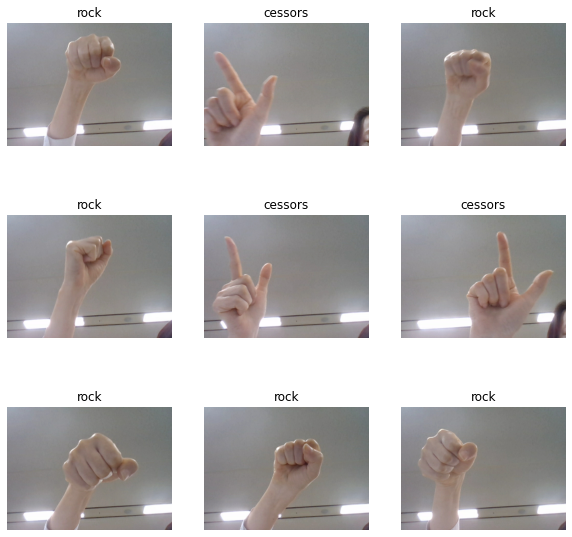

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

잠시 후에 이들 데이터세트를 `model.fit`에 전달하여 모델을 훈련하겠습니다. 원하는 경우, 데이터세트를 수동으로 반복하고 이미지 배치를 검색할 수도 있습니다.

In [ ]:
type(train_ds)

tensorflow.python.data.ops.dataset_ops.PrefetchDataset

In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 240, 320, 3)
(32,)


`image_batch`는 `(32, 240, 320, 3)` 형상의 텐서이며, `240x320x3` 형상의 32개 이미지 묶음으로 되어 있습니다(마지막 차원은 색상 채널 RGB를 나타냄). `label_batch`는 형상 `(32,)`의 텐서이며 32개 이미지에 해당하는 레이블입니다.

`image_batch` 및 `labels_batch` 텐서에서 `.numpy()`를 호출하여 이를 `numpy.ndarray`로 변환할 수 있습니다.


## 성능을 높이도록 데이터세트 구성하기

I/O가 차단되지 않고 디스크에서 데이터를 얻을 수 있도록 버퍼링된 프리페치를 사용하겠습니다. 다음은 데이터를 로드할 때 사용해야 하는 두 가지 중요한 메서드입니다.

- `Dataset.cache()`는 첫 epoch 동안 디스크에서 이미지를 로드한 후 이미지를 메모리에 유지합니다. 이렇게 하면 모델을 훈련하는 동안 데이터세트가 병목 상태가 되지 않습니다. 데이터세트가 너무 커서 메모리에 맞지 않는 경우, 이 메서드를 사용하여 성능이 높은 온디스크 캐시를 생성할 수도 있습니다.
- `Dataset.prefetch`는 훈련하는 동안 데이터 전처리 및 모델 실행을 중첩시킵니다.

관심 있는 독자는 <a>tf.data API를 통한 성능 향상</a> 가이드의 <em>프리페치</em> 섹션에서 두 가지 메서드와 데이터를 디스크에 캐시하는 방법에 대해 자세히 알아볼 수 있습니다.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## 데이터 표준화하기

RGB 채널 값은 `[0, 255]` 범위에 있습니다. 이것은 신경망에 이상적이지 않습니다. 일반적으로 입력 값을 작게 만들어야 합니다.

여기에서 `tf.keras.layers.Rescaling`을 사용하여 값을 `[0, 1]` 범위로 표준화합니다.

In [ ]:
normalization_layer = layers.Rescaling(1./255)

In [ ]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image)) 

0.03137255 1.0


# 모델 만들기

[순차](https://www.tensorflow.org/guide/keras/sequential_model) 모델은 각각에 최대 풀링 레이어(`tf.keras.layers.MaxPooling2D`)가 있는 3개의 컨볼루션 블록(`tf.keras.layers.Conv2D`)으로 구성됩니다. ReLU 활성화 함수(`'relu'`)에 의해 활성화되는 128개 유닛이 있는 완전 연결된 레이어(`tf.keras.layers.Dense`)가 있습니다. 이 모델은 높은 정확도를 위해 조정되지 않았습니다. 이 튜토리얼의 목표는 표준 접근 방식을 보여주는 것입니다.

In [ ]:
num_classes = len(class_names)

model = Sequential([
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(64, activation='relu'),
  layers.Dense(32, activation='relu'),
  layers.Dense(num_classes)
])

## 모델 컴파일하기

이 튜토리얼에서는 `tf.keras.optimizers.Adam` 옵티마이저와 `tf.keras.losses.SparseCategoricalCrossentropy` 손실 함수를 선택합니다. 각 훈련 epoch에 대한 훈련 및 검증 정확도를 보려면 `metrics` 인수를 `Model.compile`에 전달합니다.

In [ ]:
model.compile(optimizer='rmsprop',
             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

## 모델 요약

모델의 `Model.summary` 메서드를 사용하여 네트워크의 모든 레이어를 봅니다.

In [ ]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_10 (Rescaling)    (None, 240, 320, 3)       0         
                                                                 
 conv2d_15 (Conv2D)          (None, 240, 320, 16)      448       
                                                                 
 max_pooling2d_15 (MaxPoolin  (None, 120, 160, 16)     0         
 g2D)                                                            
                                                                 
 conv2d_16 (Conv2D)          (None, 120, 160, 32)      4640      
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 60, 80, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_17 (Conv2D)          (None, 60, 80, 64)       

## 모델 훈련하기

In [ ]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50
11/11 [==============================] - 2s 74ms/step - loss: 1.2147 - accuracy: 0.5260 - val_loss: 0.6938 - val_accuracy: 0.5185
Epoch 2/50
11/11 [==============================] - 1s 56ms/step - loss: 0.7675 - accuracy: 0.4985 - val_loss: 0.6920 - val_accuracy: 0.5185
Epoch 3/50
11/11 [==============================] - 1s 56ms/step - loss: 0.6912 - accuracy: 0.4924 - val_loss: 0.7107 - val_accuracy: 0.4815
Epoch 4/50
11/11 [==============================] - 1s 59ms/step - loss: 0.6949 - accuracy: 0.5749 - val_loss: 0.7171 - val_accuracy: 0.4815
Epoch 5/50
11/11 [==============================] - 1s 57ms/step - loss: 0.6746 - accuracy: 0.6177 - val_loss: 0.6894 - val_accuracy: 0.4815
Epoch 6/50
11/11 [==============================] - 1s 58ms/step - loss: 0.6661 - accuracy: 0.6636 - val_loss: 0.5864 - val_accuracy: 0.6667
Epoch 7/50
11/11 [==============================] - 1s 55ms/step - loss: 0.6126 - accuracy: 0.6881 - val_loss: 0.5156 - val_accuracy: 0.8272
Epoch 8/50
11

## 훈련 결과 시각화하기
훈련 및 검증 세트에 대한 손실 및 정확도 플롯을 생성합니다.

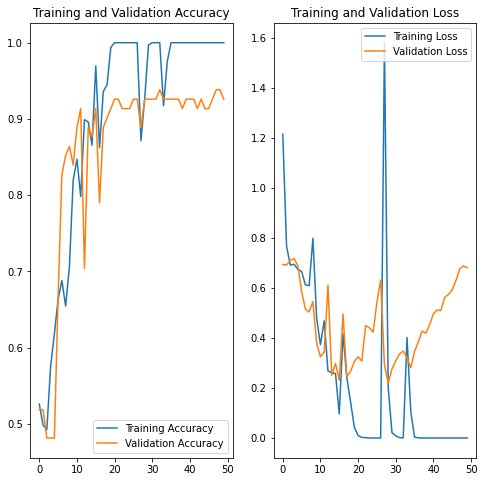

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 새로운 데이터로 예측하기

마지막으로, 모델을 사용하여 훈련 또는 검증 세트에 포함되지 않은 이미지를 분류해 보겠습니다.

참고: 데이터 증강 및 드롭아웃 레이어는 추론 시 비활성화됩니다.

In [ ]:
#sunflower_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/592px-Red_sunflower.jpg"
#sunflower_path = tf.keras.utils.get_file('Red_sunflower', origin=sunflower_url)
sunflower_path = '/content/data/rock/img_20221116-004002898819.jpg'
img = tf.keras.utils.load_img(
    sunflower_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)

img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 15ms/step
This image most likely belongs to rock with a 100.00 percent confidence.


In [ ]:
# import dependencies
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
import cv2
import numpy as np
import PIL
import io
import html
import time

In [ ]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [ ]:
# JavaScript to properly create our live video stream using our webcam as input
def video_stream():
  js = Javascript('''
    var video;
    var div = null;
    var stream;
    var captureCanvas;
    var imgElement;
    var labelElement;
    
    var pendingResolve = null;
    var shutdown = false;
    
    function removeDom() {
       stream.getVideoTracks()[0].stop();
       video.remove();
       div.remove();
       video = null;
       div = null;
       stream = null;
       imgElement = null;
       captureCanvas = null;
       labelElement = null;
    }
    
    function onAnimationFrame() {
      if (!shutdown) {
        window.requestAnimationFrame(onAnimationFrame);
      }
      if (pendingResolve) {
        var result = "";
        if (!shutdown) {
          captureCanvas.getContext('2d').drawImage(video, 0, 0, 320, 240);
          result = captureCanvas.toDataURL('image/jpeg', 0.8)
        }
        var lp = pendingResolve;
        pendingResolve = null;
        lp(result);
      }
    }
    
    async function createDom() {
      if (div !== null) {
        return stream;
      }

      div = document.createElement('div');
      div.style.border = '2px solid black';
      div.style.padding = '3px';
      div.style.width = '100%';
      div.style.maxWidth = '600px';
      document.body.appendChild(div);
      
      const modelOut = document.createElement('div');
      modelOut.innerHTML = "<span>Status:</span>";
      labelElement = document.createElement('span');
      labelElement.innerText = 'No data';
      labelElement.style.fontWeight = 'bold';
      modelOut.appendChild(labelElement);
      div.appendChild(modelOut);
           
      video = document.createElement('video');
      video.style.display = 'block';
      video.width = div.clientWidth - 6;
      video.setAttribute('playsinline', '');
      video.onclick = () => { shutdown = true; };
      stream = await navigator.mediaDevices.getUserMedia(
          {video: { facingMode: "environment"}});
      div.appendChild(video);

      imgElement = document.createElement('img');
      imgElement.style.position = 'absolute';
      imgElement.style.zIndex = 1;
      imgElement.onclick = () => { shutdown = true; };
      div.appendChild(imgElement);
      
      const instruction = document.createElement('div');
      instruction.innerHTML = 
          '<span style="color: red; font-weight: bold;">' +
          'When finished, click here or on the video to stop this demo</span>';
      div.appendChild(instruction);
      instruction.onclick = () => { shutdown = true; };
      
      video.srcObject = stream;
      await video.play();

      captureCanvas = document.createElement('canvas');
      captureCanvas.width = 320; //video.videoWidth;
      captureCanvas.height = 240; //video.videoHeight;
      window.requestAnimationFrame(onAnimationFrame);
      
      return stream;
    }
    async function stream_frame(label, imgData) {
      if (shutdown) {
        removeDom();
        shutdown = false;
        return '';
      }

      var preCreate = Date.now();
      stream = await createDom();
      
      var preShow = Date.now();
      if (label != "") {
        labelElement.innerHTML = label;
      }
            
      if (imgData != "") {
        var videoRect = video.getClientRects()[0];
        imgElement.style.top = videoRect.top + "px";
        imgElement.style.left = videoRect.left + "px";
        imgElement.style.width = videoRect.width + "px";
        imgElement.style.height = videoRect.height + "px";
        imgElement.src = imgData;
      }
      
      var preCapture = Date.now();
      var result = await new Promise(function(resolve, reject) {
        pendingResolve = resolve;
      });
      shutdown = false;
      
      return {'create': preShow - preCreate, 
              'show': preCapture - preShow, 
              'capture': Date.now() - preCapture,
              'img': result};
    }
    ''')

  display(js)
  
def video_frame(label, bbox):
  data = eval_js('stream_frame("{}", "{}")'.format(label, bbox))
  return data

In [ ]:
# start streaming video from webcam
video_stream()
# label for video
label_html = 'Capturing...'
# initialze bounding box to empty
bbox = ''
count = 0 
while True:
    try:
        js_reply = video_frame(label_html, bbox)
        if not js_reply:
            break

        # convert JS response to OpenCV Image
        frame = js_to_image(js_reply["img"])

        # create transparent overlay for bounding box
        bbox_array = np.zeros([240,320,4], dtype=np.uint8)

        # predict digit on video frame
        #img_digit = cv2.resize(img_digit, (320, 240), interpolation=cv2.INTER_AREA)

        img_input = frame.reshape(1, 240, 320, 3)

        predictions = model.predict(img_input, verbose=0)
        score = tf.nn.softmax(predictions[0])

        #print(score)

        font = cv2.FONT_HERSHEY_COMPLEX  
        fontScale = 1.1
        bbox_array = cv2.putText(bbox_array, " {} {:.2f} %".format(class_names[np.argmax(score)], 100 * np.max(score)), \
            (0, 30), font, fontScale, (0,255,0), 2)

    except Exception as e:
        print(e)
        #pass

    bbox_array[:,:,3] = (bbox_array.max(axis = 2) > 0 ).astype(int) * 255
    # convert overlay of bbox into bytes
    bbox_bytes = bbox_to_bytes(bbox_array)
    # update bbox so next frame gets new overlay
    bbox = bbox_bytes

<IPython.core.display.Javascript object>